# Задание: Реализовать интерполяцию траектории с несколькими точками (по параграфу 9.3 MODERN ROBOTICS, Kevin M. Lynch and Frank C. Park)

Цель состоит в том, чтобы шарниры робота проходили через ряд точек перехода в определенное время без строгой спецификации формы пути между последовательными точками, простое решение состоит в том, чтобы использовать полиномиальную интерполяцию для непосредственного нахождения истории соединений θ(t). без указания начала пути θ(s), а затем масштабирования по времени s(t) (рис. 9.7).

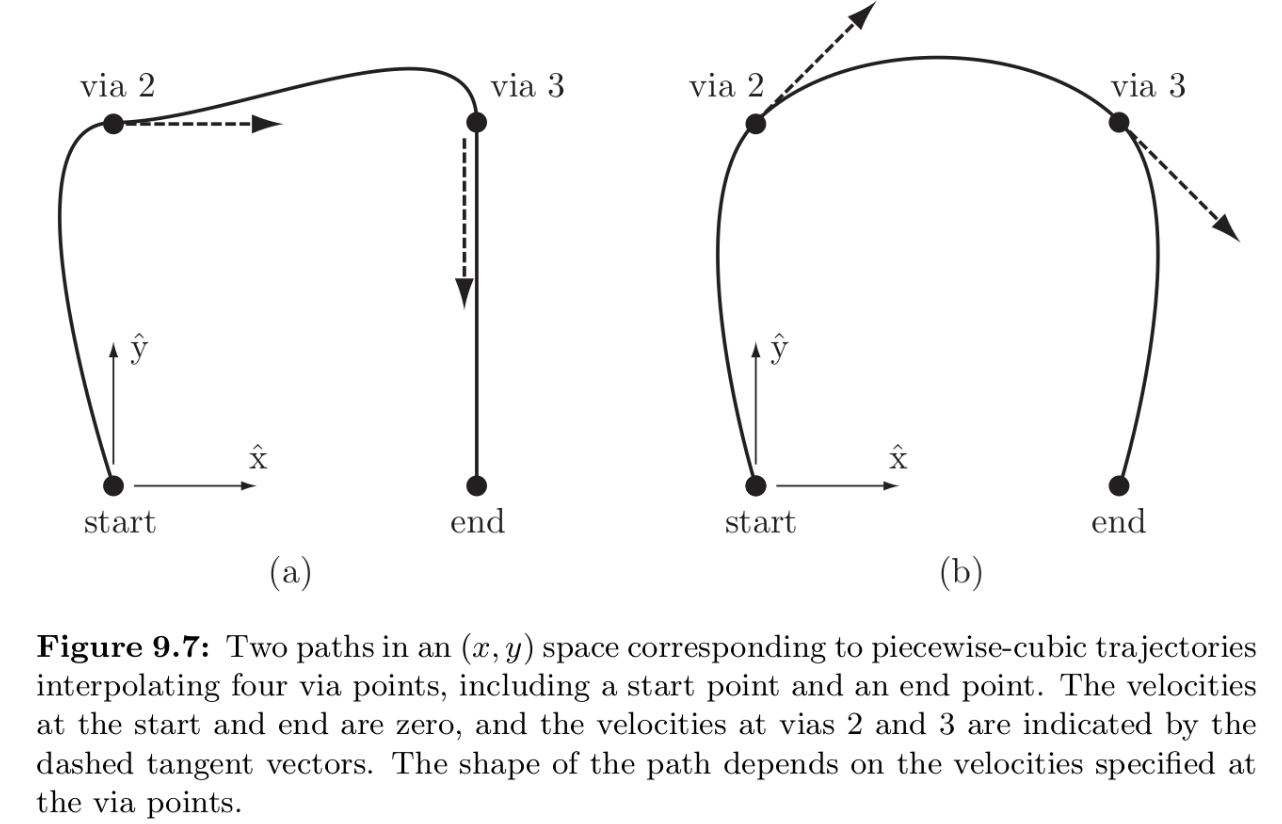

Пусть траектория задана через $k$ точек, с начальной точкой в $T_{1} = 0$ и конечной точкой в $T_{k} = T$ . Поскольку каждая совместная история интерполируется индивидуально, мы фокусируемся на одной совместной переменной и называем ее β, чтобы избежать увеличения числа индексов. В каждой промежуточной точке $i ∈ {1, . . . , k}$, пользователь указывает желаемое положение $\beta(T_i) = \beta_i$ и скорость $\dot{\beta}(T_i) = \dot{\beta}_i$. Траектория состоит из $k − 1$ отрезков, а длительность отрезка $j ∈ {1, . . . , k − 1}$ есть $∆T_j = T_{j+1} − T_j$ .

Совместная траектория на участке j выражается полиномом третьего порядка

$\begin{equation}\beta(T_j+\Delta t) = a_{j0} + a_{j1} \Delta t + a_{j2} \Delta t^2 + a_{j3} \Delta t^3\end{equation}$

через время $∆t$, прошедшее на участке $j$, где $0 ≤ ∆t ≤ ∆T_j$. 

Сегмент j подчиняется четырем ограничениям

$\beta(T_j)=\beta_j$

$\dot{\beta}(T_j)=\dot{\beta}_j$

$\beta(T_j+\Delta T_j)=\beta_{j+1}$

$\dot{\beta}(T_j+\Delta T_j) = \dot{\beta}_{j+1}$ 

Решение этих ограничений для $a_{jo},...,a_{j3}$ дает

$a_{j0}=\beta_j$

$a_{j1}=\dot{\beta}_j$

$a_{j2}=\frac{3\beta_{j+1}-3\beta_{j}-2\dot{\beta}_j\Delta T_j-\dot{\beta}_{j+1}\Delta T_j}{\Delta T_j^2}$

$a_{j3}=\frac{2\beta_{j}+(\dot{\beta}_j+\dot{\beta}_{j+1})\Delta T_j-2\beta_{j+1}}{\Delta T_j^3}$


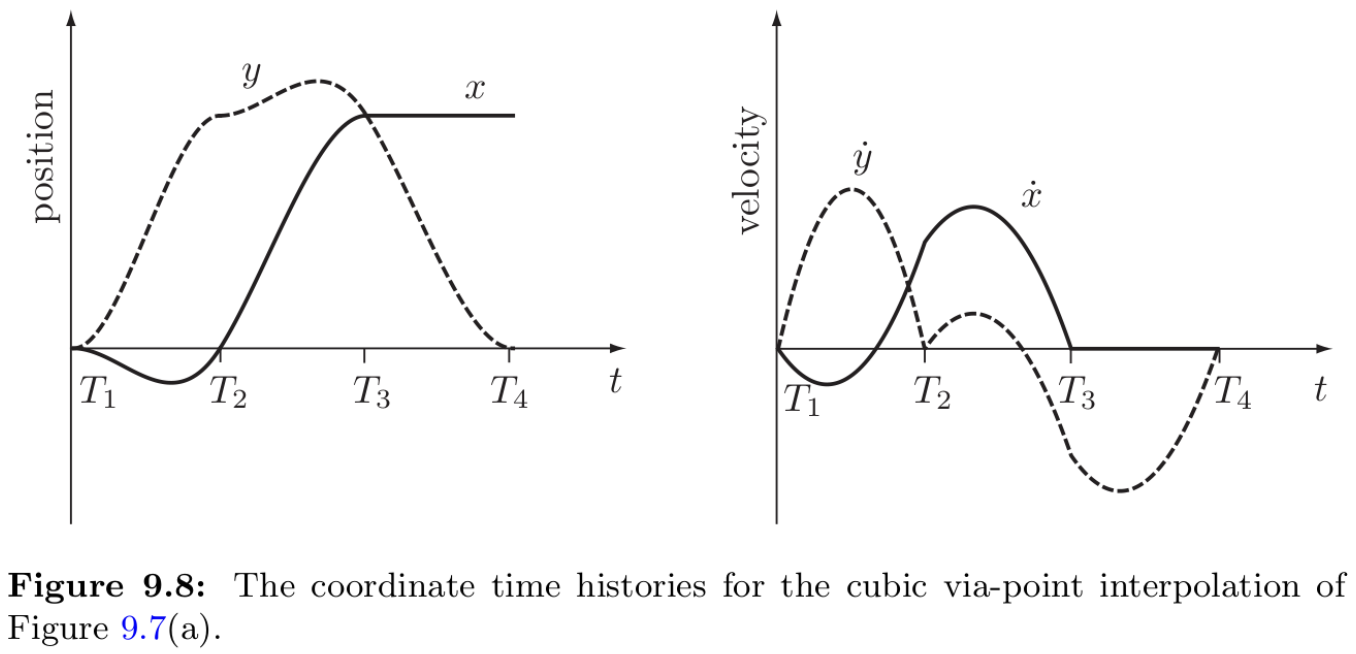

На рис. 9.8 показаны временные графики интерполяции рис. 9.7(а).
В этом двумерном $(x, y)$ координатном пространстве промежуточные точки $1,...,4$ происходят в моменты времени $T_1 = 0$, $T_2 = 1$, $T_3 = 2$ и $T_4 = 3$. Точки перехода находятся в точках $(0, 0)$, $(0, 1)$, $(1, 1)$ и $(1, 0)$ со скоростями $(0, 0)$, $(1, 0)$, $(0, −1)$ и $(0, 0)$.

Проблема:

Кубическая интерполяция промежуточных точек обеспечивает непрерывность скоростей в промежуточных точках, но не ускорений. Подход легко обобщается на использование полиномов пятого порядка и задание ускорений в промежуточных точках за счет увеличения сложности решения.

In [84]:
import matplotlib.pyplot as plt
import numpy as np

Входные данные, соответствующие примеру из учебника

In [85]:
input_x = [0,0,1,1]
input_y = [0,1,1,0]
input_v_x = [0,1,0,0]
input_v_y = [0,0,-1,0]
input_t = [0,1,2,3]

### Функции для интерполяции полиномом 3-его порядка

In [86]:
def get_inter_coef(T:list, betta:list, d_betta:list):
  '''
  Генерация коэффициентов для полинома
  
  input:
      betta - см обозначения из параграфа 9.3
      d_betta - производная betta
      T - см обозначения из параграфа 9.3
  output: 
      time-[coef list] dict
  '''
  return {T[j]: [betta[j],
                 d_betta[j],
                 (3*betta[j+1] - 3*betta[j] - 2*d_betta[j]* (T[j+1] - T[j]) - d_betta[j+1] * (T[j+1] - T[j]))/((T[j+1] - T[j]) ** 2),
                 (2*betta[j] + (d_betta[j] + d_betta[j+1])*(T[j+1] - T[j]) - 2*betta[j+1])/((T[j+1] - T[j]) ** 3),
                ] for j in range(len(T) - 1)}

In [87]:
def get_polinom_value(coefs:list, delta_time:float):
  '''
  Вычисление значения полинома по приращению времени при заданных коэффициентах
  '''
  beta = 0
  for index, coef in enumerate(coefs):
    beta += coef * delta_time**index
  return beta

def get_derivation_polinom_value(coefs:list, delta_time:float):
  '''
  Вычисление значения производной полинома по приращению времени при заданных коэффициентах
  '''
  beta = 0
  for index, coef in enumerate(coefs[1:]):
    beta += coef * (index+1) * delta_time**(index)
  return beta

def get_second_derivation_polinom_value(coefs:list, delta_time:float):
  '''
  Вычисление значения второй производной полинома по приращению времени при заданных коэффициентах
  '''
  beta = 0
  for index, coef in enumerate(coefs[2:]):
    beta += coef * (index+1)* (index+2) * delta_time**(index)
  return beta

In [88]:
class InterLine:
    '''
    Класс линии на графике, заданной кусочно с помощью
    коэффициентов полинома на промежутках времени
    '''
    
    def __init__(self,name:str, time_coefs_dict:dict[list],linestyle:str='solid', color:str='k'):
        self.color = color
        self.linestyle = linestyle
        self.name = name
        self.time_coefs_dict = time_coefs_dict

    def count_dot_values(self,func,times,index,time_range):
      return [func(self.time_coefs_dict[times[index]],dot_time-times[index]) for dot_time in time_range]

    def plot(self, ax, times, func):
      dot_x = []
      dot_y = []
      
      # Считаем мин разность между последовательными элементами в массиве времен,
      # чтобы сопоставить минимальному промежутку 100 точек для отображения графика,
      # а для остальных отрезков масштабировать количество точек
      diff_list = np.diff(times)
      min_diff = np.min(diff_list)
        
      for index,time in enumerate(times[1:]):
        delta_time = time - times[index]
        
        num_of_dote = round(delta_time/min_diff)*100
        
        time_range = np.linspace(times[index], time, num_of_dote)
        dot_values = self.count_dot_values(func,times,index,time_range)
        
        dot_x+=list(time_range)
        dot_y+=dot_values
        
      ax.plot(dot_x,dot_y,label=self.name,linestyle=self.linestyle,color =self.color)


def plot_position_and_velocity(time_coefs_dict_x: dict[list],time_coefs_dict_y: dict[list], times:list):
  '''
  Построение графика зависимости координат и скорости от времени
  '''
  fig, axis = plt.subplots(1, 2, figsize=(10, 4))

  y_labels = ('Position','Velocity')

  x = InterLine(color='red',linestyle='solid',name='x', time_coefs_dict=time_coefs_dict_x)
  y = InterLine(color='blue',linestyle='dashed',name='y', time_coefs_dict=time_coefs_dict_y)
  lines = (x,y)

  func_list = (get_polinom_value, get_derivation_polinom_value)

  for func,ax,y_label in zip(func_list,axis,y_labels):
    for line in lines:
      line.plot(ax,times,func)

    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Times')
    ax.set_ylabel(y_label)
    ax.legend(['x', 'y'])
    
  # Отображение графиков
  plt.tight_layout()
  plt.show()

def plot_position_velocity_acceleration(time_coefs_dict_x: dict[list],time_coefs_dict_y: dict[list], times:list):
  '''
  Построение графика зависимости координат,скорости и ускорения от времени
  '''
  fig, axis = plt.subplots(1, 3, figsize=(15, 6))

  y_labels = ('Position','Velocity',"Acceleration")

  x = InterLine(color='red',linestyle='solid',name='x', time_coefs_dict=time_coefs_dict_x)
  y = InterLine(color='blue',linestyle='dashed',name='y', time_coefs_dict=time_coefs_dict_y)
  
  lines = (x,y)

  func_list = (get_polinom_value, get_derivation_polinom_value, get_second_derivation_polinom_value)

  for func,ax,y_label in zip(func_list,axis,y_labels):
    for line in lines:
      line.plot(ax,times,func)

    ax.axhline(0, color='black', linewidth=0.5)
    ax.axvline(0, color='black', linewidth=0.5)
    ax.set_xlabel('Times')
    ax.set_ylabel(y_label)
    ax.legend(['x', 'y'])
    
  # Отображение графиков
  plt.tight_layout()
  plt.show()

### Решение

In [89]:
coef_x = get_inter_coef(input_t, input_x, input_v_x)
coef_y = get_inter_coef(input_t, input_y, input_v_y)

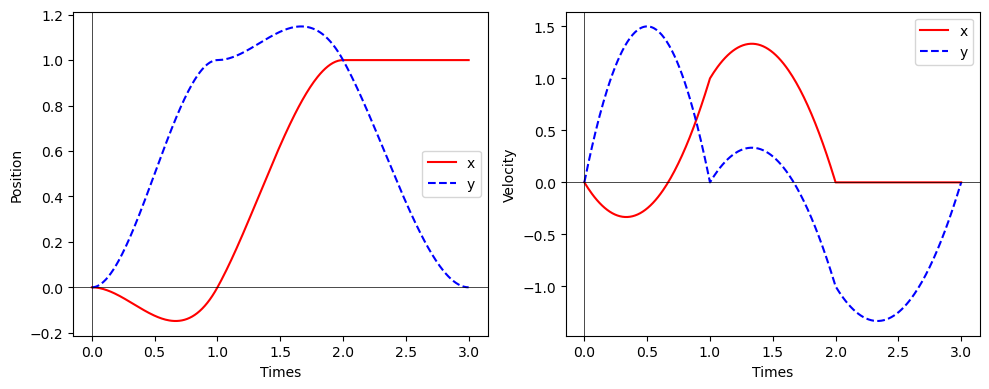

In [90]:
plot_position_and_velocity(coef_x, coef_y, input_t)

### Интерполяция полиномом 5-ого порядка

Для интерполяции полиномом 5-ого порядка необходимо ввести еще два ограничения на ускорения:

$\ddot{\beta}(T_j)=\ddot{\beta}_j$ 

$\ddot{\beta}(T_j+\Delta T_j) = \ddot{\beta}_{j+1}$  

Дополнительные входные данные для задания ускорения:

In [91]:
input_a_x = [1,1,0,1]
input_a_y = [1,0,1,1]

In [92]:
def solve_system_to_find_coefs(input_x:list,
                               input_y:list,
                               input_v_x:list,
                               input_v_y:list,
                               input_a_x:list,
                               input_a_y:list,
                               input_t:list,
                               )->[dict[list],dict[list]]:
    '''
    Решение систем ограничений для нахождения коэффициентов полиномов 5-ых порядков,
    задающих интерполяцию траектории.
    
    input:
      input_x - list координат заданных точек по x
      input_y - list координат заданных точек по y
      input_v_x - list скоростей заданных точек по x
      input_v_y - list скоростей заданных точек  по y
      input_a_x - list ускорений заданных точек по x
      input_a_y - list ускорений заданных точек по x
      input_t - list времен для заданных точек
    output: 
      [ time-[coef list] dict, time-[coef list] dict ]
      словарь: время - список коэффциентов интерполяционного полинома
    '''

    inputs=(input_x,input_y)
    inputs_v=(input_v_x,input_v_y)
    inputs_a=(input_a_x,input_a_y)
    time_coef_dicts = [{},{}]

    for input,input_v,input_a,time_coef_dict in zip(inputs,inputs_v,inputs_a,time_coef_dicts):
        for i in range((len(input_t)-1)):
            d_t = input_t[i+1] - input_t[i]
            # Коэффициенты линейных уравнений
            A_eq = np.array([[1, *[0 for _ in range(5)]],[d_t**i for i in range(6)],
                  [0,1,*[0 for _ in range(4)]], [i*d_t**(i-1) for i in range(6)],
                 [0,0,1,*[0 for _ in range(3)]], [0,0,*[(i+2)*(i+1)*d_t**(i) for i in range(4)]]]) # Коэффициенты левой части уравнений
            b_eq = np.array([input[i], input[i+1],input_v[i], input_v[i+1],input_a[i],input_a[i+1]])  # Правая часть уравнений
            result = np.linalg.solve(A_eq, b_eq)
            time_coef_dict[input_t[i]] = result

    return time_coef_dicts

In [93]:
time_coef_dict_x,time_coef_dict_y = solve_system_to_find_coefs(input_x,input_y,input_v_x,input_v_y,input_a_x,input_a_y,input_t)

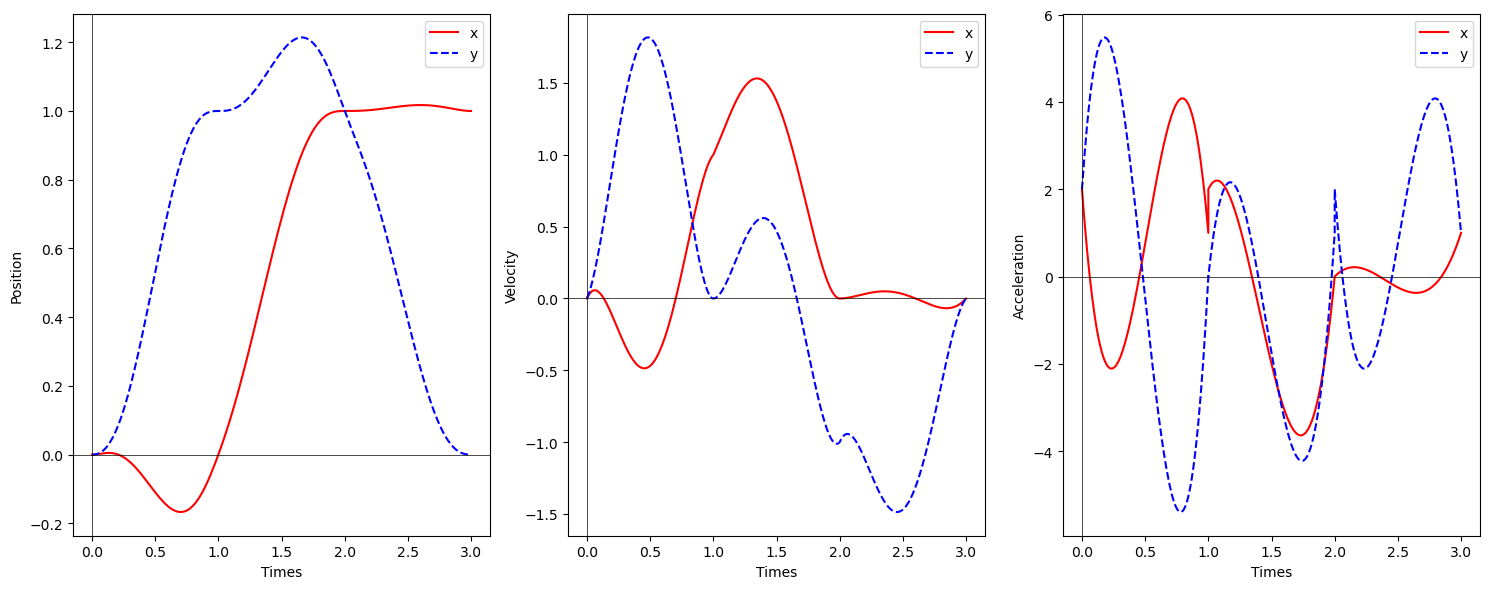

In [94]:
plot_position_velocity_acceleration(time_coef_dict_x, time_coef_dict_y, input_t)